# Localized Homicide Clearance Rates, 1995-present


In [1]:
import os
import sqlite3
import pandas as pd


## Data Import

In [2]:
def should_chdir():
    """checks whether the code is being run interactively or from command line"""
    # if both these directories exist, treat is as the correct directory
    dirs = ["input", "output"]
    if all(os.path.exists(d) for d in dirs):
        return False

    try:
        shell = get_ipython().__class__.__name__  # type: ignore
        if shell == "ZMQInteractiveShell":
            return True
        elif shell == "TerminalInteractiveShell":
            return False
        else:
            return False
    except NameError:
        return False


# step backwards if notebook is being run interactively
# or stay put if being run from command line
if should_chdir():
    os.chdir("..")


In [3]:
with sqlite3.connect("input/sqlite__temp.db") as con:
    agencies = pd.read_sql("SELECT * FROM data_agencies;", con)
    gb_cols = "ori_code, card, year"
    reta = pd.read_sql(
        f"""
        SELECT {gb_cols}, SUM(value) as total
        FROM data_reta
        GROUP BY {gb_cols};
    """,
        con,
    )


### Merging geographies

In [4]:
df = reta.merge(
    agencies,
    how="left",
    left_on=["ori_code", "year"],
    right_on=["ori", "data_year"],
)


### Filtering unwanted records

In [5]:
# FDLK24000 is for federal agencies, which all use the same ORI and won't be included here
df = df[df.ori_code != "FDLK24000"]


#### Selecting data only from agencies that regularly reported >1 clearance

This data contains zeros for both agencies that reported no data, and agencies that actually reported zero clearances. For example, the Chicago Police Department reported hundreds of homicides each year but no clearances at all

In [6]:
df[df.ori_code == "ILCPD0000"].pivot(index="year", columns="card", values="total")


card,actual,cleared_arrest
year,,
1995,824,0
1996,789,0
1997,757,0
1998,703,0
1999,642,0
2000,631,0
2001,666,0
2002,648,0
2003,598,0


To address this, I'm only going to look at agencies that reported at least 1 clearance to the FBI in at least ~90% of the years we're looking at; in this case, 23 out of the 26 years (~88.5%). This approach is adapted from [Jeremy Singer-Vine's excellent analysis](https://github.com/the-trace-and-buzzfeed-news/federal-crime-data-analysis/blob/master/notebooks/analyze/00-analyze-reta.ipynb) of this data in 2018 for Buzzfeed News. 

In [7]:
MIN_NONZERO_CLEARANCE_YEARS = 23
INCLUDE_AGENCIES_MERGE_COLS = ["ori_code"]

include_agencies = (
    pd.crosstab(
        index=[df.year, df.ori_code],
        columns=df.card,
        values=df.total,
        aggfunc=sum,
    )
    .assign(nonzero_clearance=lambda df: df.cleared_arrest > 0)
    .reset_index()
    .groupby(INCLUDE_AGENCIES_MERGE_COLS)
    .nonzero_clearance.sum()
    .to_frame("nonzero_clearance_years")
    .query("nonzero_clearance_years > @MIN_NONZERO_CLEARANCE_YEARS")
)

include_agencies


,nonzero_clearance_years
ori_code,
AK0010100,26
AL0020000,24
AL0110100,26
AL0630000,24
AR0160100,25
...,...
WI0130100,24
WI0520200,24
WIMPD0000,26


Select only rows in the original dataframe that are in include_agencies

In [8]:
df = df.merge(
    include_agencies, how="right", left_on=INCLUDE_AGENCIES_MERGE_COLS, right_index=True
).drop("nonzero_clearance_years", axis=1)

df


,ori_code,card,year,total,unique_id,data_year,ori,ncic_agency_name,state_abbr,county_name,msa_name,city_name
0,AK0010100,actual,1995,29,00be478396bcfdd84f9361c6ed83ca28b167b0fd,1995.0,AK0010100,ANCHORAGE PD,AK,ANCHORAGE,"Ames, IA",ANCHORAGE
1,AK0010100,actual,1996,25,ccc6735b0cb84b86330d20e09a4105a29542a540,1996.0,AK0010100,ANCHORAGE PD,AK,ANCHORAGE,"Ames, IA",ANCHORAGE
2,AK0010100,actual,1997,23,ec895861f02e61281526c06303cffaf7f160c2df,1997.0,AK0010100,ANCHORAGE PD,AK,ANCHORAGE,"Ames, IA",ANCHORAGE
3,AK0010100,actual,1998,19,16c8416a45081736b85ca65ab08f492bf65d8e33,1998.0,AK0010100,ANCHORAGE PD,AK,ANCHORAGE,"Ames, IA",ANCHORAGE
4,AK0010100,actual,1999,19,4503dee76665fda72813b58373430cf6f3eca029,1999.0,AK0010100,ANCHORAGE PD,AK,ANCHORAGE,"Ames, IA",ANCHORAGE
...,...,...,...,...,...,...,...,...,...,...,...,...
1083121,WV0200200,cleared_arrest,2016,5,2ea033e3f0fe5025cc2d32cf1b8c7f101da3a859,2016.0,WV0200200,CHARLESTON PD,WV,KANAWHA,"Charleston, WV",CHARLESTON
1083122,WV0200200,cleared_arrest,2017,6,442ed5a00abbbaefa2eb14c8117ac0b0b9cf5e7f,2017.0,WV0200200,CHARLESTON PD,WV,KANAWHA,"Charleston, WV",CHARLESTON
1083123,WV0200200,cleared_arrest,2018,3,2c33fb670bcb80354d495a93da69f0825ba01e8a,2018.0,WV0200200,CHARLESTON PD,WV,KANAWHA,"Charleston, WV",CHARLESTON
1083124,WV0200200,cleared_arrest,2019,1,574cc587168ac2792f5ca6dba04aede3c69ec7d6,2019.0,WV0200200,CHARLESTON PD,WV,KANAWHA,"Charleston, WV",CHARLESTON


## Analysis

In [9]:
# helper functions that will generate tables used in multiple tasks below


def get_clearance_rate_df(index):
    """creates a crosstab of totals and clearance rates with a given index"""

    if isinstance(index, (str, int, float)):
        index = df[index]
    elif isinstance(index, list):
        index = [df[i] for i in index]
    else:
        raise ValueError("index must be a column name or list of column names")

    return pd.crosstab(
        index=index, columns=df.card, values=df.total, aggfunc=sum
    ).assign(clearance_rate=lambda d: d.cleared_arrest / d.actual)


def get_2020(clearance_df, index_col):
    """generates a subset of clearance_df with only 2020 numbers"""
    return (
        clearance_df[clearance_df.year == 2020]
        .set_index(index_col)
        .drop("year", axis=1)
    )


def get_5yravg_vs_2020(clearance_df, groupby_col):
    """
    generates a dataframe with the 2020 clearance rate, the 2015-2019 average,
    and a percent change column
    """
    avgcol = "2015_2019_avg"
    return (
        clearance_df[clearance_df.year.isin(range(2015, 2020))]
        .groupby(groupby_col)
        .clearance_rate.mean()
        .to_frame(avgcol)
        .join(
            clearance_df[clearance_df.year == 2020].set_index(groupby_col)[
                ["clearance_rate"]
            ]
        )
        .rename(columns={"clearance_rate": 2020})
        .assign(change=lambda df: (df[2020] - df[avgcol]) / df[avgcol])
    )


### National

Of these agencies we're looking at, overall, the clearance rate fell from a high of about 65% in the late 90s to about 52% in 2020.

In [10]:
national = get_clearance_rate_df("year")
national


card,actual,cleared_arrest,clearance_rate
year,,,
1995,11999,7255,0.604634
1996,10619,6419,0.604483
1997,9920,6155,0.620464
1998,8960,5773,0.644308
1999,8100,5255,0.648765
2000,8468,4955,0.585144
2001,8923,5122,0.574022
2002,9274,5541,0.597477
2003,9392,5574,0.593484


<AxesSubplot:xlabel='year'>

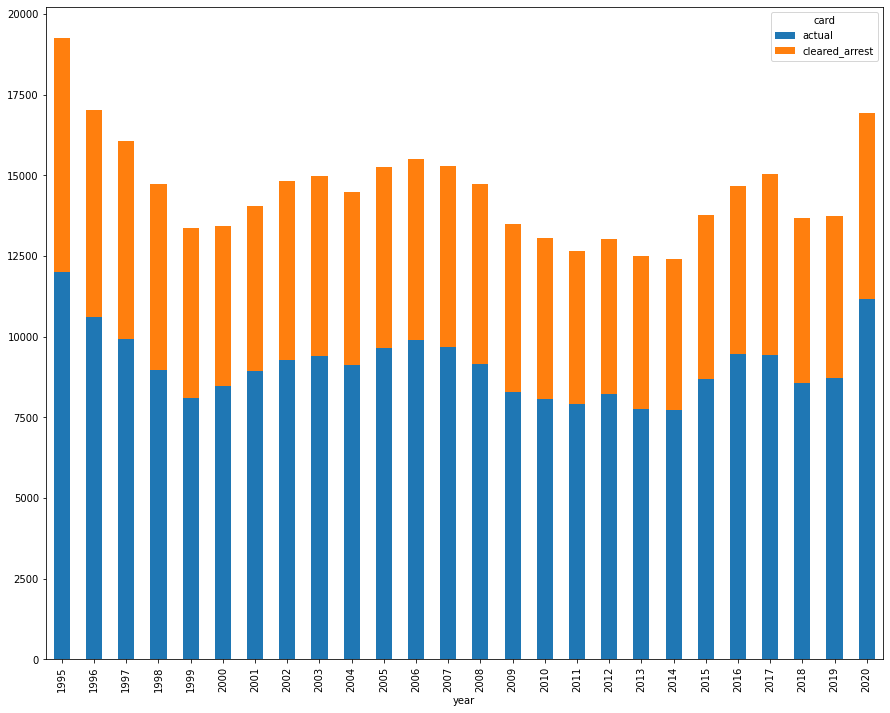

In [11]:
national[["actual", "cleared_arrest"]].plot(kind="bar", stacked=True, figsize=(15, 12))


In [12]:
national.to_csv("output/national.csv")


### By state

In [13]:
state = get_clearance_rate_df(["year", "state_abbr"]).reset_index()
state.columns.name = None
state


,year,state_abbr,actual,cleared_arrest,clearance_rate
0,1995,AK,29,19,0.655172
1,1995,AL,11,6,0.545455
2,1995,AR,115,75,0.652174
3,1995,AZ,387,216,0.558140
4,1995,CA,2585,1406,0.543907
...,...,...,...,...,...
983,2020,UT,23,13,0.565217
984,2020,VA,337,200,0.593472
985,2020,WA,147,80,0.544218
986,2020,WI,209,120,0.574163


In [14]:
# output for use in later tasks
state.to_csv("output/state.csv", index=False)


Clearance rates can vary wildly from state to state. Some are as low as 11%, while others are more than 70%

In [15]:
state_2020 = get_2020(state, "state_abbr")

state_2020.sort_values("clearance_rate")


,actual,cleared_arrest,clearance_rate
state_abbr,,,
RI,17,2,0.117647
NM,89,20,0.224719
DE,46,12,0.260870
GA,231,71,0.307359
MA,90,30,0.333333
IN,293,106,0.361775
WV,24,9,0.375000
OH,551,208,0.377495
PA,248,96,0.387097


In [16]:
# output for later use
state_2020.to_csv("output/state_2020.csv")


Most states saw a decline in clearance rates in 2020 compared to the previous 5 years


In [17]:
state_5yr = get_5yravg_vs_2020(state, "state_abbr")

state_5yr.sort_values("change")


,2015_2019_avg,2020,change
state_abbr,,,
NM,0.481300,0.224719,-0.533100
DE,0.528328,0.260870,-0.506236
RI,0.235531,0.117647,-0.500503
GA,0.574649,0.307359,-0.465135
TN,0.560806,0.396552,-0.292889
PA,0.536473,0.387097,-0.278441
NY,0.541996,0.391304,-0.278031
UT,0.753808,0.565217,-0.250184
MA,0.441995,0.333333,-0.245844


In [18]:
# output for later tasks
state_5yr.to_csv("output/state_5yr.csv")


### Localized analysis

The cells below are used to calculate columns that will be used in later analyses

#### By MSA

In [19]:
msa = get_clearance_rate_df(["year", "msa_name"]).reset_index()

msa


card,year,msa_name,actual,cleared_arrest,clearance_rate
0,1995,"Abilene, TX",5,2,0.400000
1,1995,"Albany, GA",14,14,1.000000
2,1995,"Albany-Schenectady-Troy, NY",15,10,0.666667
3,1995,"Albuquerque, NM",53,9,0.169811
4,1995,"Alexandria, LA",7,7,1.000000
...,...,...,...,...,...
4684,2020,"Wichita Falls, TX",9,6,0.666667
4685,2020,"Wilmington, NC",22,14,0.636364
4686,2020,"Winston-Salem, NC",2,2,1.000000
4687,2020,"Worcester, MA-CT",10,6,0.600000


In [20]:
msa.to_csv("output/msa.csv", index=False)


In [21]:
msa_2020 = get_2020(msa, "msa_name")

# looking here only at agencies with 50 or more homicides in 2020
msa_2020.query("actual > 50").dropna(subset=["clearance_rate"])


card,actual,cleared_arrest,clearance_rate
msa_name,,,
"Albuquerque, NM",80,14,0.175000
"Atlanta-Sandy Springs-Alpharetta, GA",205,55,0.268293
"Bakersfield, CA",103,34,0.330097
"Baltimore-Columbia-Towson, MD",345,169,0.489855
"Baton Rouge, LA",114,72,0.631579
"Boston-Cambridge-Newton, MA-NH",62,19,0.306452
"Buffalo-Cheektowaga, NY",61,15,0.245902
"Charleston-North Charleston, SC",76,45,0.592105
"Charlotte-Concord-Gastonia, NC-SC",144,97,0.673611


In [22]:
# output for use in later tasks
msa_2020.to_csv("output/msa_2020.csv")


In [23]:
msa_5yr = get_5yravg_vs_2020(msa, "msa_name")

msa_5yr.dropna(subset=["change"]).sort_values("change")


,2015_2019_avg,2020,change
msa_name,,,
"Ocala, FL",0.636190,0.000000,-1.000000
"Flint, MI",0.108120,0.022727,-0.789796
"Vallejo, CA",0.701190,0.151515,-0.783917
"Visalia, CA",1.293121,0.294118,-0.772552
"Raleigh-Cary, NC",0.800000,0.250000,-0.687500
...,...,...,...
"Fort Wayne, IN",0.442396,0.846154,0.912661
"Racine, WI",0.750000,1.500000,1.000000
"Lincoln, NE",0.858333,1.800000,1.097087


In [24]:
# output for use in later tasks
msa_5yr.to_csv("output/msa_5yr.csv")


#### By agency

In [25]:
agency = get_clearance_rate_df(["year", "ori_code", "ncic_agency_name"]).reset_index()

agency


card,year,ori_code,ncic_agency_name,actual,cleared_arrest,clearance_rate
0,1995,AK0010100,ANCHORAGE PD,29,19,0.655172
1,1995,AL0020000,MOBILE CO SO MOBILE,3,0,0.000000
2,1995,AL0110100,ANNISTON PD,6,4,0.666667
3,1995,AL0630000,TUSCALOOSA CO SO TUSCALOOSA,2,2,1.000000
4,1995,AR0160100,JONESBORO PD,3,1,0.333333
...,...,...,...,...,...,...
9927,2020,WI0130100,MADISON PD,10,7,0.700000
9928,2020,WI0520200,RACINE PD,2,3,1.500000
9929,2020,WIMPD0000,MILWAUKEE PD,191,103,0.539267
9930,2020,WV0200000,KANAWHA CO SO CHARLESTON,13,6,0.461538


In [26]:
agency.to_csv("output/agency.csv", index=False)


In [27]:
agency_2020 = get_2020(agency, "ori_code")

# using this in later step
agency_2020_subset = agency_2020.query("actual > 25").dropna(subset=["clearance_rate"])

# again looking only at ones with many homicides in 2020
agency_2020_subset.sort_values("clearance_rate")


card,ncic_agency_name,actual,cleared_arrest,clearance_rate
ori_code,,,,
MI2539800,FLINT PD,44,1,0.022727
CA0480700,VALLEJO PD,27,1,0.037037
OHCLP0000,CLEVELAND,160,17,0.106250
NM0010100,ALBUQUERQUE PD,80,14,0.175000
CA0150000,KERN CO SO BAKERSFIELD,59,11,0.186441
...,...,...,...,...
TX2270100,AUSTIN PD,44,38,0.863636
NB0280200,OMAHA PD,37,32,0.864865
FL0480400,ORLANDO PD,31,27,0.870968


In [28]:
# output for use in later tasks
agency_2020.to_csv("output/agency_2020.csv")


In [29]:
agency_5yr = get_5yravg_vs_2020(agency, ["ori_code", "ncic_agency_name"])

agency_5yr[
    agency_5yr.index.get_level_values("ori_code").isin(
        agency_2020_subset.index.get_level_values("ori_code")
    )
].sort_values("change")


,,2015_2019_avg,2020,change
ori_code,ncic_agency_name,,,
CA0480700,VALLEJO PD,0.620556,0.037037,-0.940316
MI2539800,FLINT PD,0.108120,0.022727,-0.789796
GAAPD0000,ATLANTA POLICE DEPARTMENT,0.804225,0.237288,-0.704948
NJ0160800,PATERSON PD,0.687893,0.222222,-0.676952
NM0010100,ALBUQUERQUE PD,0.481177,0.175000,-0.636308
...,...,...,...,...
FL0480400,ORLANDO PD,0.576945,0.870968,0.509619
GA0440200,DE KALB COUNTY PD DECATUR,0.122599,0.214286,0.747857
CA0390500,STOCKTON PD,0.368760,0.660714,0.791720


In [30]:
agency_5yr.to_csv("output/agency_5yr.csv")
